In [265]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from utility import *
import numpy as np
import tensorflow as tf

%matplotlib inline

In [266]:
model=load_vgg_model('pretrained-model/imagenet-vgg-verydeep-19_1.mat')
print "Model Loaded"

conv1_1
Model Loaded


(300, 400, 3)


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


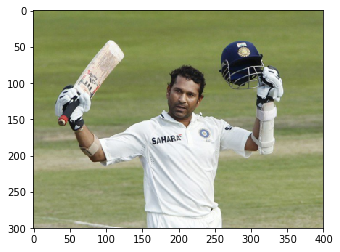

In [268]:
contentimage=scipy.misc.imread('input/sachin.png')
print contentimage.shape
imshow(contentimage)

In [269]:
def content_cost(a_C,a_G):
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    a_C_unrolled=tf.transpose(tf.reshape(a_C,shape=(-1,n_H*n_W)))
    a_G_unrolled=tf.transpose(tf.reshape(a_G,shape=(-1,n_H*n_W)))
    J_content = (1/float (4* n_H * n_W * n_C)) * tf.reduce_sum(tf.pow((a_G_unrolled - a_C_unrolled), 2))
    return J_content

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


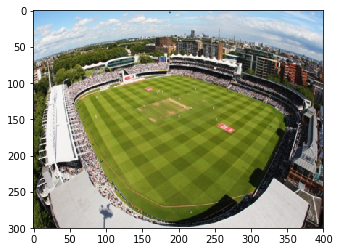

In [270]:
style_image = scipy.misc.imread("input/lords.png")
imshow(style_image)

In [271]:
def grammatrix(A):
    return tf.matmul(A,tf.transpose(A))

In [272]:
def compute_layer_style_cost(a_S, a_G):
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    a_S = tf.transpose(tf.reshape(a_S, [n_H*n_W, n_C]))
    a_G = tf.transpose(tf.reshape(a_G, [n_H*n_W, n_C]))
    Gramstyle = grammatrix(a_S)
    Gramgenerated = grammatrix(a_G)
    J_style_layer = (1./(4 * n_C**2 * (n_H*n_W)**2)) * tf.reduce_sum(tf.pow((Gramstyle - Gramgenerated), 2))
    return J_style_layer

In [273]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

In [274]:
def style_cost(model,stylelayers):
    cost=0
    for layername,layervalue in stylelayers:
        out=model[layername]
        a_S=sess.run(out)
        a_G=out #a_G is a tensor and will be evaluated when we will run iterations
        subcost=compute_layer_style_cost(a_S,a_G)
        cost+=layervalue*subcost
    return cost   

In [257]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    J = alpha * J_content + beta * J_style
    return J

In [276]:
def reshape_and_normalize_image(img):
    
    """Input image to be changed to match the dimensions of VGG model
    """
   
    means = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3))
    image = np.reshape(img, ((1,) + img.shape))
    
    # Substract the mean to match the expected input of VGG16
    image = image - means
    
    return image

In [277]:
def generate_noise_image(content_image, noise_ratio=0.6):
    noise_image = np.random.uniform(-20, 20,(1, 300, 400, 3)).astype('float32')
    input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)

    return input_image

In [278]:
def save_image(path, image):
    image = image + CONFIG.MEANS
    
    # Clip and Save the image
    image = np.clip(image[0], 0, 255).astype('uint8')
    scipy.misc.imsave(path, image)

In [279]:
tf.reset_default_graph()

# Start interactive session
sess = tf.InteractiveSession()

In [281]:
content_image = scipy.misc.imread("input/sachin.png")
content_image = reshape_and_normalize_image(content_image)
print content_image.shape
# imshow(content_image[0])

(1, 300, 400, 3)


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


In [282]:
style_image = scipy.misc.imread("input/lords.png")
style_image = reshape_and_normalize_image(style_image)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


In [283]:
generated_image = generate_noise_image(content_image)

In [284]:
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19_1.mat")

conv1_1


In [287]:
sess.run(model['input'].assign(content_image))
out = model['conv4_2']
a_C = sess.run(out)
a_G = out
J_content = content_cost(a_C,a_G)

In [288]:
sess.run(model['input'].assign(style_image))

# Compute the style cost
J_style = style_cost(model, STYLE_LAYERS)

In [289]:
J = total_cost(J_content, J_style, alpha = 10, beta = 40)

In [290]:
optimizer = tf.train.AdamOptimizer(2.0)

# define train_step (1 line)
train_step = optimizer.minimize(J)

In [292]:
def model_nn(sess, input_image, num_iterations = 200):
    sess.run(tf.global_variables_initializer())
    sess.run(model['input'].assign(input_image))
    for i in range(num_iterations):
        sess.run(train_step)
        print "performing Iteration "+str(i)
        generated_image = sess.run(model['input'])
        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            # save current generated image in the "/output" directory
            save_image("output/" + str(i) + ".png", generated_image)
            print "Written"
    
    # save last generated image
    save_image('output/generated_image.jpg', generated_image)
    
    return generated_image

In [293]:
model_nn(sess, generated_image)

performing Iteration 0
Iteration 0 :
total cost = 4157001000.0
content cost = 5369.9385
style cost = 103923680.0
Written


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  


performing Iteration 1
performing Iteration 2
performing Iteration 3
performing Iteration 4
performing Iteration 5
performing Iteration 6
performing Iteration 7
performing Iteration 8
performing Iteration 9
performing Iteration 10
performing Iteration 11
performing Iteration 12
performing Iteration 13
performing Iteration 14
performing Iteration 15
performing Iteration 16
performing Iteration 17
performing Iteration 18
performing Iteration 19
performing Iteration 20
Iteration 20 :
total cost = 814389440.0
content cost = 9752.829
style cost = 20357298.0
Written
performing Iteration 21
performing Iteration 22
performing Iteration 23
performing Iteration 24
performing Iteration 25
performing Iteration 26
performing Iteration 27
performing Iteration 28
performing Iteration 29
performing Iteration 30
performing Iteration 31
performing Iteration 32
performing Iteration 33
performing Iteration 34
performing Iteration 35
performing Iteration 36
performing Iteration 37
performing Iteration 38
p

KeyboardInterrupt: 